In [5]:
# Descargamos el modelo pre-entrenado.
# Cargamos las librerías
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [6]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [7]:
iv3 = InceptionV3()

96116736/96112376 [==============================] - 9s 0us/step


In [9]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [42]:
# Importar imagenes
from keras.preprocessing import image
################################
###  IMAGEN DE LA CERVEZA    ###
################################
# Como queremos que la imagen sea una matriz multidimensional, la imagen la convertimos en matriz
x= image.img_to_array(image.load_img("./images/beer.png", target_size=(299,299)))
# Forma de la matriz ==> x.shape ; el valor 3 es la profundidad de los pixeles.
# print(x.shape)
# Re-escalar el rango de la matriz de 0-255 -> 0-1
x /= 255
x -= 0.5
x *= 2
# print(x)
# print("-------Forma de la matriz re-escalada-------")
# print(x.shape)
# Si queremos pararle más de una imagen a la vez
x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])


In [43]:
# Las posibilidades que pueden haber son 1000, es el tamaño del vector. 
# Para cada una de las clases de la matriz obtenemos una probabilidad por ende 
# tenemos una probabilidad de cada clase de 1000 vectores.
y.shape
y
# Insertamos en la var. Y el tensor de la imagen de cat.jpg o variable 'x'
y = iv3.predict(x)
# Para ver el resultado de la predicción, interpretar los 1000 vectores para 
# nosotros es complicado, tendríamos que hacer un máximo de todas las clases 
# para obtener el de mayor probabilidad y tener las posibles respuestas válidas.
# Sin embargo, existe en 'keras', la función 'decode' que mapea las probabilidades 
# y las proporciona ordanadas todas las clases existentes
decode_predictions(y)

[[('n02823750', 'beer_glass', 0.66887623),
  ('n02823428', 'beer_bottle', 0.014603832),
  ('n03950228', 'pitcher', 0.00983702),
  ('n03063599', 'coffee_mug', 0.009237602),
  ('n03530642', 'honeycomb', 0.007958862)]]

In [49]:
################################
###     IMAGEN DEL GATO      ###
################################
# Como queremos que la imagen sea una matriz multidimensional, la imagen la convertimos en matriz
z= image.img_to_array(image.load_img("./images/cat.jpg", target_size=(299,299)))
# Re-escalar el rango de la matriz de 0-255 -> 0-1
z /= 255
z -= 0.5
z *= 2
z = z.reshape([1, z.shape[0], z.shape[1], z.shape[2]])
# Insertamos en la var. Y el tensor de la imagen de cat.jpg o variable 'x'
a = iv3.predict(z)
# Vemos los resultados
decode_predictions(a)

[[('n02124075', 'Egyptian_cat', 0.22831301),
  ('n02123394', 'Persian_cat', 0.224939),
  ('n02123045', 'tabby', 0.15617882),
  ('n02127052', 'lynx', 0.08919183),
  ('n02123597', 'Siamese_cat', 0.040873315)]]

###  Ataques adversarios
- Tipos de datos que le introduces a la red neuronal y la 'confundes' porque aunque al ojo humano unas imagenes sean iguales, la red neuronal dice algo diferente que el cerebro humano diría.

In [74]:
# Cogemos la primera capa del primer punto de entrada y salida de iv3
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# Queremos un grafo para maximizar una clase para confundir la red neuronal.
# Queremos que la imagen del gato maximice que sea 'un limon'
target_class = 951

# La Probabil. de 951 sea mayor, para conseguir la maximización
# Funcion de coste
loss = out_layer[0, target_class]

# Creamos el gradiante para que se use en la variable de entrada 
# Ponemos indice 0 para que nos devuelva un array
grad = K.gradients(loss,inp_layer)[0]

# Creamos una funcion que se ejecutará iterativamente para que con el gradiante calculado anteriormente
# se asemeje al valor deseado, 'el del limon = 951'.

# Modos de funcion de Keras:
# - Modo entrenando 
# - Modo testing
# ||||||||||||||||
# vvvvvvvvvvvvvvvv
# k.learning_phase - > valor de entrada para el modelo
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
# Como los datos de la variable que tenemos almacenada en el vector de la imagen del gato 'z' 
# van a cambiar porla clase que quiero crear, hago una copia de la misma
adv = np.copy(z)

# Cuando se haga la perturbacion de la imagen,l debemos limitarla para que la RN se mantenga en un rango de 
# valores que pueda manipular - perturbacion
pert = 0.01

max_pert = x + 0.009
min_pert = x - 0.009

cost = 0.0

# Iteración de un 95%
while cost < 0.95:
    gr,cost = optimize_gradient([adv,0])
    adv += gr 
    # Para los valres mayores a la maxima perturbación, lo satura al igual con los menores con clip()
    # La ayuda de una funcion es con: np.clip?
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv,-1,1)
    print("Lemon cost:" , cost)
hacked_img = np.copy(adv)

Lemon cost: 0.00022754949
Lemon cost: 0.00023791888
Lemon cost: 0.00024924777
Lemon cost: 0.0002611411
Lemon cost: 0.00027409988
Lemon cost: 0.00028867775
Lemon cost: 0.0003040901
Lemon cost: 0.00032049857
Lemon cost: 0.00033793814
Lemon cost: 0.00035660094
Lemon cost: 0.00037654492
Lemon cost: 0.00039801112
Lemon cost: 0.00042271943
Lemon cost: 0.00045027622
Lemon cost: 0.0004804427
Lemon cost: 0.0005132374
Lemon cost: 0.00055009406
Lemon cost: 0.00059084716
Lemon cost: 0.00063551747
Lemon cost: 0.00068754633
Lemon cost: 0.00075436704
Lemon cost: 0.0008346799
Lemon cost: 0.00092581054
Lemon cost: 0.0010294038
Lemon cost: 0.0011515365
Lemon cost: 0.0012998375
Lemon cost: 0.0014783781
Lemon cost: 0.0017076836
Lemon cost: 0.0019997992
Lemon cost: 0.0022499927
Lemon cost: 0.0027996588
Lemon cost: 0.0032894497
Lemon cost: 0.004095722
Lemon cost: 0.004809239
Lemon cost: 0.0066244868
Lemon cost: 0.0078112474
Lemon cost: 0.008665064
Lemon cost: 0.014562205
Lemon cost: 0.017157003
Lemon cost: 

In [75]:
# Revertimos el valor de adv 0-1 => 0-255
adv /= 2
adv += 0.5
adv *= 255

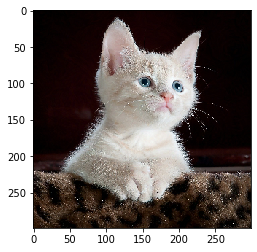

In [76]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [77]:
from PIL import Image
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("./images/img_hacked.png")

In [78]:
# Cargamos la nueva imagen del gato manipulada.
z= image.img_to_array(image.load_img("./images/img_hacked.png", target_size=(299,299)))
# Re-escalamos
z /= 255
z -= 0.5
z *= 2
z = z.reshape([1, z.shape[0], z.shape[1], z.shape[2]])
a = iv3.predict(z)
# Vemos los resultados
decode_predictions(a)

[[('n07749582', 'lemon', 0.9993487),
  ('n09229709', 'bubble', 9.226664e-05),
  ('n07747607', 'orange', 7.46641e-05),
  ('n02823750', 'beer_glass', 2.8664794e-05),
  ('n02123159', 'tiger_cat', 2.5476644e-05)]]